sources: https://stackoverflow.com/questions/61297312/finding-the-bounding-boxes-of-different-symbols-letters

In [1]:
import numpy as np
import keras
from keras import layers
import cv2
import pickle
import os

from matplotlib import pyplot as plt
from pygments.formatters import img

# Segmentation using bounding boxes


In [33]:
def find_bboxes(img):
    bboxes = []
    
    # store state of img after each stage
    img_stages = []
    
    #turn image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_stages.append(gray)
    
    #binarisation
    ret, binary_inv = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    img_stages.append(binary_inv)

    #dilation
    kernel_dilate = np.ones((3,3), np.uint8)
    imgDilate = cv2.dilate(binary_inv, kernel_dilate, iterations=5)
    img_stages.append(imgDilate)
    
    #finding contours
    contours, _ = cv2.findContours(imgDilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #find bboxes    
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        bboxes.append(bbox)
            
    #draw bbox on img
    bbox_img = img.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
    
    img_stages.append(bbox_img) 
    
    return bboxes, img_stages

def load_equations(dir):
    imgs = []
    for imgName in os.listdir(dir):
        img = cv2.imread(os.path.join(dir, imgName), cv2.COLOR_BGR2GRAY)
        imgs.append(img)
    
    return imgs

def IntersectionOverArea(bbox1, bbox2):
    #finding top left and bottom right corner of first bbox
    x1, y1, w1, h1 = bbox1
    A1 = (x1, y1)
    B1 = (x1 + w1, y1 + h1)

    #finding top left and bottom right corner of the second bbox
    x2, y2, w2, h2 = bbox2
    A2 = (x2, y2)
    B2 = (x2 + w2, y2 + h2)

    # Intersection over Union
    # Area of intersection
    # _____________________ x
    # | 
    # |  A1
    # |
    # |
    # |      A2
    # |         B1
    # |
    # |                 B2
    # y

    # x determine the (x, y)-coordinates of the intersection rectangle
    xA = max(A1[0], A2[0])
    yA = max(A1[1], A2[1])
    xB = min(B1[0], B2[0])
    yB = min(B1[1], B2[1])

    # area of the intersection rectangle
    
    interArea = max(0, xB-xA+1) * max(0, yB-yA+1)

    # area of the first input box
    Area1 = (B1[0] - A1[0] +1)*(B1[1] - A1[1]+1)

    # area of intersection/area of box1
    IoA = interArea/float(Area1)
    return IoA


def orderBboxesByX(bboxes):
    return sorted(bboxes, key=lambda x: x[0])

def removeBBoxOverlap(bboxes):

    arrayLen = len(bboxes)

    noOverlapBBoxes = bboxes.copy()


    # iterate through all bounding box combinations 
    # improvement: use x coordinate and width and y coordinate and height 
    # to check for possible overlaps
    for i in range(arrayLen):
        for j in range(arrayLen):
            if j == i:
                pass
            else:
                IoA = IntersectionOverArea(bboxes[i], bboxes[j])
                if IoA > 0.8:
                    try:
                        noOverlapBBoxes.remove(bboxes[i])
                    except:
                        pass
    print(len(noOverlapBBoxes))
    return noOverlapBBoxes



def visualiseBBoxes(img, bboxes):

    #draw bbox on img
    bbox_img = img.copy()
    print(bboxes)

    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
        cv2.putText(bbox_img, str(i), (start_point[0], start_point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    return bbox_img







9
[(132, 40, 238, 411), (408, 321, 34, 39), (511, 197, 50, 229), (566, 309, 29, 40), (655, 201, 155, 209), (908, 265, 113, 51), (1038, 272, 29, 39), (1096, 211, 49, 172), (1205, 226, 58, 262)]


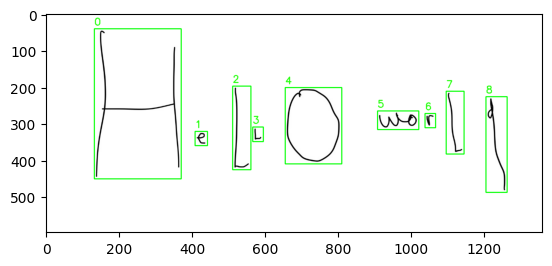

In [42]:
imgs = load_equations(r"C:\Users\b_wen\PythonProjects\HandMtoLat\test_equations")
img = imgs[3]
bboxes, img_stages = find_bboxes(img)
# display all images 

# plt.figure(figsize=(20,10))
# columns = 4

# for i, image in enumerate(img_stages):
#     plt.subplot(int(len(img_stages) / columns + 1), columns, i + 1)
#     plt.title(i)
#     plt.imshow(image)


plt.figure()
symbolBBoxes = removeBBoxOverlap(bboxes)
orderdSymbolBBoxes = orderBboxesByX(symbolBBoxes)
plt.imshow(visualiseBBoxes(img, orderdSymbolBBoxes))


#currently only works on dark text to light background
# 


# Structural analysis